# 1 - Fundamental Level Sets : 

## Introduction 
Instead of representing the active contour explicitly by a set of ordered point, We define the contour implicitely by the zero level set of a function phi(x,y), by evolving this function in time we can approch our desired contour.

## Mathematical Formulation

The basic level set method represents a contour 𝐶 implicitly as the zero level set of a higher-dimensional function ϕ(x,y,t), where:
- (x,y) are spatial coordinates
- t is time/iteration
- The contour C is defined where ϕ(x,y,t) = 0

The contour evolution is governed by the level set equation:

$$\frac{\partial \phi}{\partial t} + F|\nabla \phi| = 0$$

Where:
- F is the speed function that controls the contour evolution
- ∇ϕ is the spatial gradient of ϕ

## Basic Algorithm Components

### 1. Level Set Function Initialization

Typically, the level set function is initialized as a signed distance function:
- ϕ(x,y,0) < 0 for points inside the initial contour
- ϕ(x,y,0) > 0 for points outside
- |ϕ(x,y,0)| represents the distance to the contour

A common initialization is:
$$\phi(x,y,0) = \pm d$$

Where d is the distance from (x,y) to the initial contour, and the sign depends on whether the point is inside (negative) or outside (positive).

### 2. Speed Function Design

For image segmentation, the speed function F typically depends on:
- Image gradient: to stop the contour at edges
- Curvature: to maintain smoothness

A basic speed function:
$$F = g(|\nabla I|)(c + \kappa)$$

Where:
- g is an edge detector function (e.g., g = 1/(1+|∇I|²))
- I is the image
- κ is the curvature of the level set
- c is a constant (balloon force)

### 3. Level Set Evolution

At each iteration, update ϕ using:
$$\phi^{n+1} = \phi^n - \Delta t \cdot F|\nabla \phi^n|$$

## Numerical Implementation

Here's how to implement this for images:

### Numerical LSF 

For a 2D image of size M×N:
- ϕ is represented as an M×N matrix
- Spatial derivatives are approximated using finite differences


### Numerical Curvature

The curvature κ is computed as:
$$\kappa = \nabla \cdot \left(\frac{\nabla \phi}{|\nabla \phi|}\right)$$

Discretized as:
$$\kappa_{i,j} = \frac{\phi_{xx}\phi_y^2 - 2\phi_x\phi_y\phi_{xy} + \phi_{yy}\phi_x^2}{(\phi_x^2 + \phi_y^2)^{3/2}}$$

Where φₓₓ, φᵧᵧ, and φₓᵧ are second derivatives.

### Time Step Selection

For stability, the time step must satisfy the CFL condition:
$$\Delta t \leq \frac{\Delta x}{max(|F|)}$$

## Complete Algorithm

```
1. Initialize φ(x,y,0) as a signed distance function
2. Calculate the edge indicator function g(|∇I|)
3. For each iteration n:
   a. Calculate ∇φⁿ using finite differences
   b. Compute curvature κ
   c. Evaluate speed function F
   d. Update φⁿ⁺¹ = φⁿ - Δt·F|∇φⁿ|
   e. Periodically reinitialize φ to maintain signed distance property
4. Extract final contour from zero level set φ = 0
```



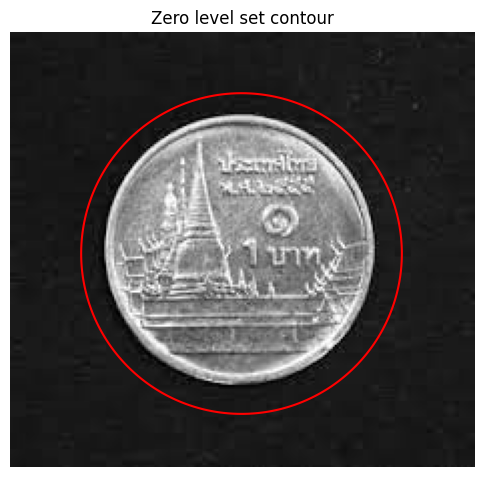

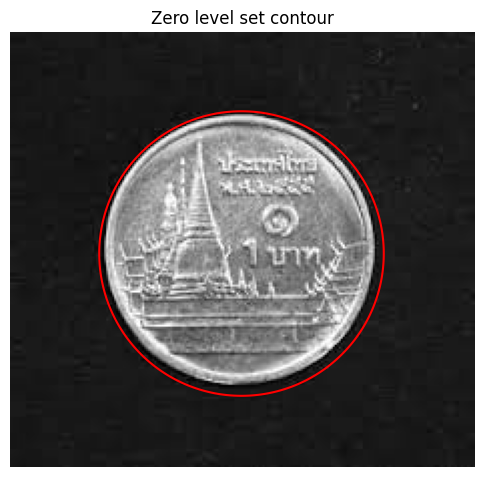

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import gaussian_filter, sobel


# 2. Initialize the level set function phi as a signed distance function (SDF)
def sdf_circle(shape, center, radius):
    y, x = np.ogrid[:shape[0], :shape[1]]
    dist = np.sqrt((x - center[1])**2 + (y - center[0])**2) - radius
    return dist

# 3. Compute curvature of the level set function
def curvature(phi):
    phi_x = sobel(phi, axis=1)
    phi_y = sobel(phi, axis=0)
    norm = np.sqrt(phi_x**2 + phi_y**2) + 1e-8  # avoid division by zero
    n_x = phi_x / norm
    n_y = phi_y / norm
    div_nx = sobel(n_x, axis=1)
    div_ny = sobel(n_y, axis=0)
    return div_nx + div_ny

# 4. Evolve the level set function using curvature flow
def evolve_level_set(phi, time_step, num_iters):
    for i in range(num_iters):
        curv = curvature(phi)
        dphi_dt = curv  # basic motion by mean curvature
        phi += time_step * dphi_dt
    return phi

# 5. Plotting the zero level contour
def plot_level_set(phi, img=None):
    plt.figure(figsize=(6, 6))
    if img is not None:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(phi, cmap='gray')
    plt.contour(phi, levels=[0], colors='r')  # zero level set
    plt.title('Zero level set contour')
    plt.axis('off')
    plt.show()

# Run the basic level set evolution
img = cv2.imread("coin.jpeg", cv2.IMREAD_GRAYSCALE)
phi_init = sdf_circle(img.shape, center=(110, 115), radius=80)
plot_level_set(phi_init, img)

phi_final = evolve_level_set(phi_init, time_step=0.1, num_iters=800)
plot_level_set(phi_final, img)


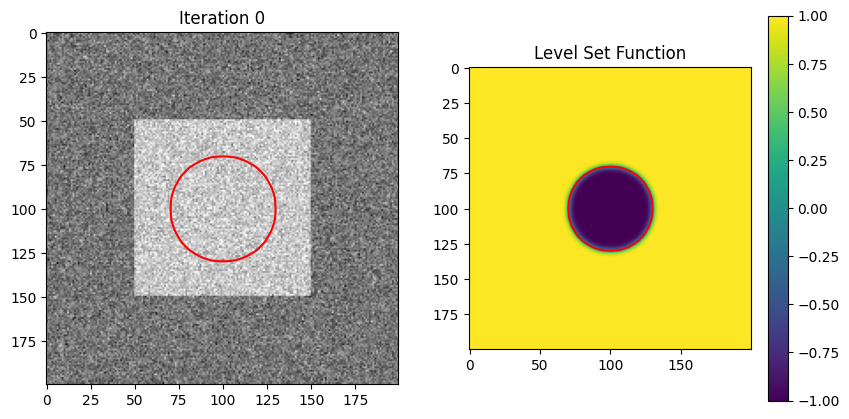

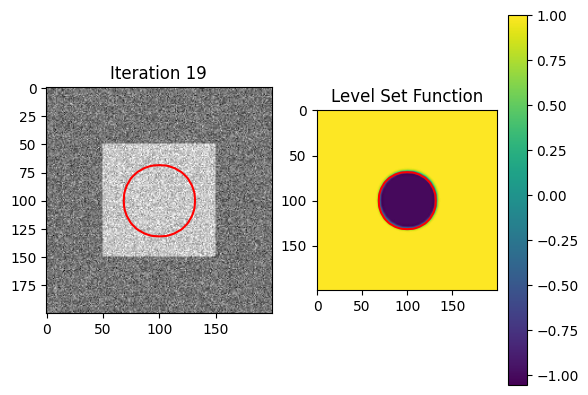

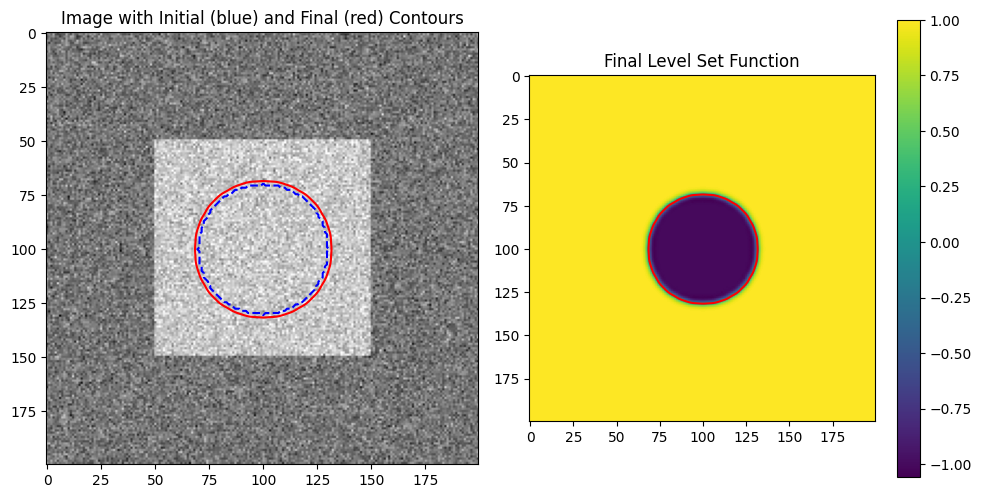

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from skimage import color, io

def initialize_phi(image_shape, init_contour):
    """
    Initialize the level set function as a signed distance function.
    
    Parameters:
    -----------
    image_shape: tuple
        Shape of the image (height, width)
    init_contour: ndarray 
        Initial contour as binary mask (1 inside, 0 outside)
        
    Returns:
    --------
    phi: ndarray
        Initialized level set function
    """
    # Initialize phi as a matrix of ones (outside the contour)
    phi = np.ones(image_shape)
    
    # Set the region inside the contour to -1
    phi[init_contour == 1] = -1
    
    # Smooth the initial level set
    phi = gaussian_filter(phi, sigma=2)
    
    return phi

def compute_curvature(phi):
    """
    Compute the curvature of the level set function.
    
    Parameters:
    -----------
    phi: ndarray
        Level set function
        
    Returns:
    --------
    kappa: ndarray
        Curvature at each point
    """
    # Compute derivatives
    dx = np.zeros_like(phi)
    dy = np.zeros_like(phi)
    dxx = np.zeros_like(phi)
    dyy = np.zeros_like(phi)
    dxy = np.zeros_like(phi)
    
    # Central differences for first derivatives
    dx[:, 1:-1] = (phi[:, 2:] - phi[:, :-2]) / 2
    dy[1:-1, :] = (phi[2:, :] - phi[:-2, :]) / 2
    
    # Central differences for second derivatives
    dxx[:, 1:-1] = phi[:, 2:] - 2*phi[:, 1:-1] + phi[:, :-2]
    dyy[1:-1, :] = phi[2:, :] - 2*phi[1:-1, :] + phi[:-2, :]
    dxy[1:-1, 1:-1] = (phi[2:, 2:] - phi[2:, :-2] - phi[:-2, 2:] + phi[:-2, :-2]) / 4
    
    # Compute curvature
    grad_sq = dx**2 + dy**2
    epsilon = 1e-10  # To avoid division by zero
    kappa = (dxx * dy**2 - 2 * dx * dy * dxy + dyy * dx**2) / (grad_sq * np.sqrt(grad_sq) + epsilon)
    
    # Handle boundary conditions
    kappa[0, :] = kappa[1, :]
    kappa[-1, :] = kappa[-2, :]
    kappa[:, 0] = kappa[:, 1]
    kappa[:, -1] = kappa[:, -2]
    
    return kappa

def compute_gradient_magnitude(phi):
    """
    Compute the gradient magnitude of phi using upwind scheme.
    
    Parameters:
    -----------
    phi: ndarray
        Level set function
        
    Returns:
    --------
    grad_mag: ndarray
        Gradient magnitude at each point
    """
    # Forward and backward differences
    dx_forward = np.zeros_like(phi)
    dx_backward = np.zeros_like(phi)
    dy_forward = np.zeros_like(phi)
    dy_backward = np.zeros_like(phi)
    
    dx_forward[:, :-1] = phi[:, 1:] - phi[:, :-1]
    dx_backward[:, 1:] = phi[:, 1:] - phi[:, :-1]
    
    dy_forward[:-1, :] = phi[1:, :] - phi[:-1, :]
    dy_backward[1:, :] = phi[1:, :] - phi[:-1, :]
    
    # Choose upwind differences based on the sign of the speed function
    # For positive speed (outward movement)
    dx_pos = np.maximum(dx_backward, 0)**2 + np.minimum(dx_forward, 0)**2
    dy_pos = np.maximum(dy_backward, 0)**2 + np.minimum(dy_forward, 0)**2
    
    # For negative speed (inward movement)
    dx_neg = np.minimum(dx_backward, 0)**2 + np.maximum(dx_forward, 0)**2
    dy_neg = np.minimum(dy_backward, 0)**2 + np.maximum(dy_forward, 0)**2
    
    # Combine into the gradient magnitude
    grad_mag_pos = np.sqrt(dx_pos + dy_pos)
    grad_mag_neg = np.sqrt(dx_neg + dy_neg)
    
    return grad_mag_pos, grad_mag_neg

def compute_edge_indicator(image, sigma=1.0):
    """
    Compute the edge indicator function g.
    
    Parameters:
    -----------
    image: ndarray
        Input image
    sigma: float
        Standard deviation for Gaussian smoothing
        
    Returns:
    --------
    g: ndarray
        Edge indicator function
    """
    # If the image is RGB, convert to grayscale
    if len(image.shape) == 3 and image.shape[2] == 3:
        image = color.rgb2gray(image)
    
    # Smooth the image
    smoothed = gaussian_filter(image, sigma)
    
    # Compute gradients
    gx = np.zeros_like(smoothed)
    gy = np.zeros_like(smoothed)
    
    gx[:, 1:-1] = (smoothed[:, 2:] - smoothed[:, :-2]) / 2
    gy[1:-1, :] = (smoothed[2:, :] - smoothed[:-2, :]) / 2
    
    # Compute edge indicator
    grad_mag = np.sqrt(gx**2 + gy**2)
    g = 1.0 / (1.0 + grad_mag**2)
    
    return g

def level_set_evolution(image, init_contour, num_iterations=100, balloon_force=1.0, 
                         alpha=0.1, delta_t=0.1, display_interval=10):
    """
    Evolve the level set contour on an image.
    
    Parameters:
    -----------
    image: ndarray
        Input image
    init_contour: ndarray
        Initial contour as binary mask
    num_iterations: int
        Number of iterations to run
    balloon_force: float
        Strength of the balloon force (c)
    alpha: float
        Weight of the curvature term
    delta_t: float
        Time step
    display_interval: int
        Interval for displaying intermediate results
        
    Returns:
    --------
    phi: ndarray
        Final level set function
    """
    # Initialize level set function
    phi = initialize_phi(image.shape[:2], init_contour)
    
    # Compute edge indicator function
    g = compute_edge_indicator(image)
    
    # Create a figure for visualization
    if display_interval > 0:
        plt.figure(figsize=(10, 5))
    
    # Main loop
    for i in range(num_iterations):
        # Compute curvature
        kappa = compute_curvature(phi)
        
        # Compute gradient magnitude with upwind scheme
        grad_mag_pos, grad_mag_neg = compute_gradient_magnitude(phi)
        
        # Set speed function with balloon force and curvature
        F = g * (balloon_force + alpha * kappa)
        
        # Update phi based on the sign of F
        phi_update = np.zeros_like(phi)
        phi_update[F > 0] = F[F > 0] * grad_mag_neg[F > 0]
        phi_update[F <= 0] = F[F <= 0] * grad_mag_pos[F <= 0]
        
        # Update level set function
        phi = phi - delta_t * phi_update
        
        # Display intermediate results
        if display_interval > 0 and (i % display_interval == 0 or i == num_iterations - 1):
            plt.clf()
            plt.subplot(1, 2, 1)
            plt.imshow(image, cmap='gray')
            plt.contour(phi, levels=[0], colors='red')
            plt.title(f'Iteration {i}')
            
            plt.subplot(1, 2, 2)
            plt.imshow(phi)
            plt.colorbar()
            plt.contour(phi, levels=[0], colors='red')
            plt.title('Level Set Function')
            
            plt.pause(0.01)
    
    return phi

def create_circular_mask(shape, center, radius):
    """
    Create a circular binary mask for initialization.
    
    Parameters:
    -----------
    shape: tuple
        Shape of the image (height, width)
    center: tuple
        Center coordinates (y, x)
    radius: float
        Radius of the circle
        
    Returns:
    --------
    mask: ndarray
        Binary mask with 1s inside the circle
    """
    y, x = np.ogrid[:shape[0], :shape[1]]
    dist_from_center = np.sqrt((y - center[0])**2 + (x - center[1])**2)
    mask = (dist_from_center <= radius).astype(np.float64)
    return mask

# Example usage
def main():
    # Load an example image
    # Replace with your image path or use a synthetic image
    image = np.ones((200, 200)) * 0.5
    # Create a synthetic image with an object
    image[50:150, 50:150] = 0.8
    
    # Add some noise
    np.random.seed(1)
    image = image + 0.1 * np.random.randn(*image.shape)
    image = np.clip(image, 0, 1)
    
    # Create initial contour (a circle)
    init_contour = create_circular_mask(image.shape, center=(100, 100), radius=30)
    
    # Run level set evolution
    phi = level_set_evolution(
        image, 
        init_contour, 
        num_iterations=20, 
        balloon_force=1.0, 
        alpha=0.2, 
        delta_t=0.1, 
        display_interval=20
    )
    
    # Display final result
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.contour(init_contour, levels=[0.5], colors='blue', linestyles='dashed')
    plt.contour(phi, levels=[0], colors='red')
    plt.title('Image with Initial (blue) and Final (red) Contours')
    
    plt.subplot(1, 2, 2)
    plt.imshow(phi)
    plt.colorbar()
    plt.contour(phi, levels=[0], colors='red')
    plt.title('Final Level Set Function')
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

### 6. Reinitialization

Over time, φ may lose its signed distance property. Reinitialization solves:
$$\frac{\partial \phi}{\partial \tau} = sign(\phi_0)(1-|\nabla \phi|)$$

Until steady state, where φ₀ is the level set function before reinitialization.

Would you like me to explain any specific part of the algorithm in more detail or demonstrate how it would be implemented in code?